In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

/opt/miniconda3/envs/mamografia/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
ruta_DE2_train = '/Users/claracelestechavezcotrina/Downloads/DATA_TESIS/datasetPublico_preprocesado_etapa2/train'
ruta_DE2_val = '/Users/claracelestechavezcotrina/Downloads/DATA_TESIS/datasetPublico_preprocesado_etapa2/val'
ruta_DE2_test = '/Users/claracelestechavezcotrina/Downloads/DATA_TESIS/datasetPublico_preprocesado_etapa2/test'

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 8   # pequeño por la escasez de datos
NUM_CLASSES = 3

In [4]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [5]:
train_gen = train_datagen.flow_from_directory(
    ruta_DE2_train,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    ruta_DE2_val,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = test_datagen.flow_from_directory(
    ruta_DE2_test,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 86 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Found 17 images belonging to 3 classes.


In [6]:
print(train_gen.class_indices)

{'birads3': 0, 'birads4': 1, 'birads5': 2}


In [7]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_train = train_gen.classes

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.7916666666666667, 1: 0.9555555555555556, 2: 0.7166666666666667}


In [8]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

2026-01-15 22:07:02.936371: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2026-01-15 22:07:02.936535: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2026-01-15 22:07:02.936539: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2026-01-15 22:07:02.936741: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-15 22:07:02.936761: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc", multi_label=True),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

In [12]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=4,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        "resnet50_etapa2_birads3_4_5.keras",
        monitor="val_loss",
        save_best_only=True
    )
]

In [13]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/40


2026-01-15 22:08:00.183890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 712ms/step - accuracy: 0.2907 - auc: 0.4470 - loss: 2.3471 - precision: 0.2933 - recall: 0.2558 - val_accuracy: 0.3000 - val_auc: 0.3940 - val_loss: 1.5545 - val_precision: 0.2941 - val_recall: 0.2500 - learning_rate: 1.0000e-04
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.3256 - auc: 0.5478 - loss: 1.7892 - precision: 0.3514 - recall: 0.3023 - val_accuracy: 0.2500 - val_auc: 0.3934 - val_loss: 1.4556 - val_precision: 0.3000 - val_recall: 0.1500 - learning_rate: 1.0000e-04
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.2907 - auc: 0.4952 - loss: 1.8740 - precision: 0.2987 - recall: 0.2674 - val_accuracy: 0.2500 - val_auc: 0.4205 - val_loss: 1.5701 - val_precision: 0.3333 - val_recall: 0.2500 - learning_rate: 1.0000e-04
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.3721 - auc: 0.5658 - loss: 1.6825 - precision: 0.3947 - recall: 0.3488 - val_accuracy: 0.3500 - val_auc: 0.4495 - val_loss: 1.2597 - v

In [14]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_gen.classes
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step  


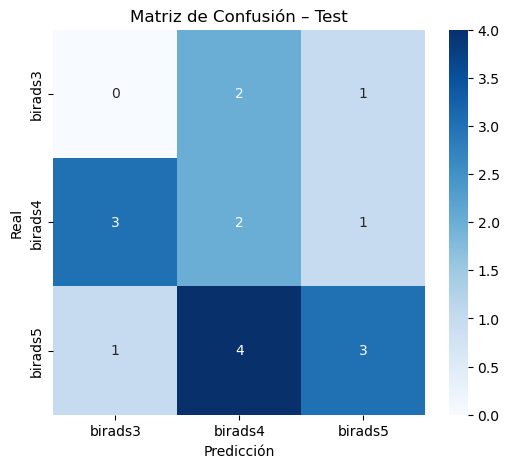

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=test_gen.class_indices.keys(),
    yticklabels=test_gen.class_indices.keys()
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión – Test")
plt.show()

In [16]:
print(classification_report(
    y_true,
    y_pred,
    target_names=test_gen.class_indices.keys()
))


              precision    recall  f1-score   support

     birads3       0.00      0.00      0.00         3
     birads4       0.25      0.33      0.29         6
     birads5       0.60      0.38      0.46         8

    accuracy                           0.29        17
   macro avg       0.28      0.24      0.25        17
weighted avg       0.37      0.29      0.32        17

